In [ ]:
run_project = input("Czy chcesz uruchomić projekt? (tak/nie): ").lower()

if run_project != 'tak':
    raise SystemExit("Projekt nie zostanie uruchomiony.")
print("Projekt uruchomiony.")

## Biblioteki

In [ ]:
from pathlib import Path
import os
import re
from collections import OrderedDict

import numpy as np
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from scipy.stats import loguniform, uniform

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    RandomizedSearchCV,
    cross_validate
)
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    matthews_corrcoef,
    roc_curve,
    precision_recall_curve,
    confusion_matrix,
    classification_report
)

from IPython.display import display

import joblib
import kagglehub


## EDA

 Załadowano 768 wierszy i 9 kolumn.



,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB

Statystyki opisowe:


,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00



Rozkład klas:


,count
Outcome,
Brak cukrzycy,500
Cukrzyca,268


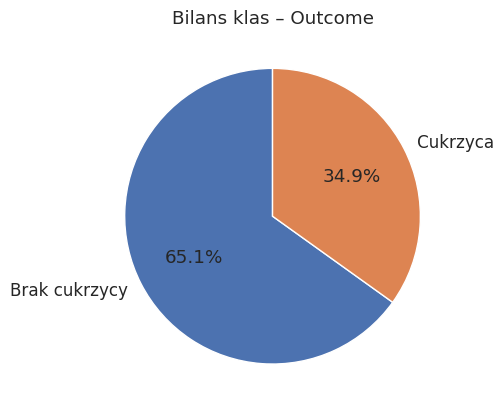


Wartości 0 (traktowane jako braki):


,Liczba zer
Glucose,5
BloodPressure,35
SkinThickness,227
Insulin,374
BMI,11


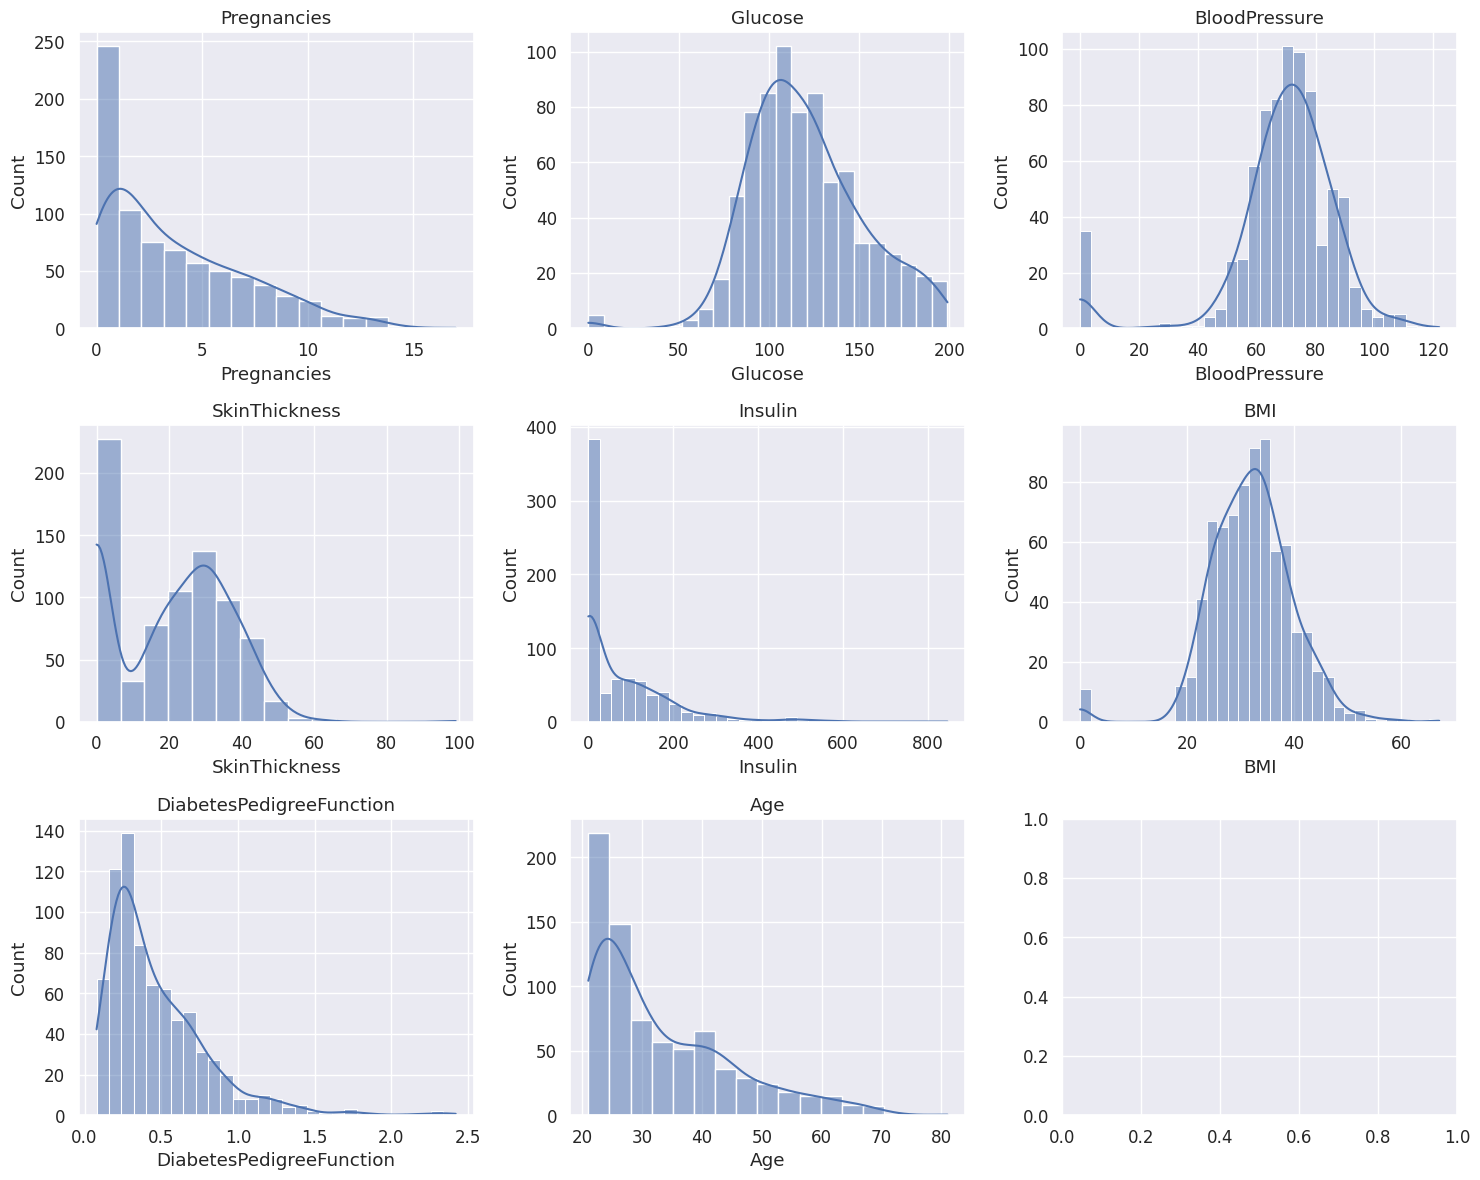

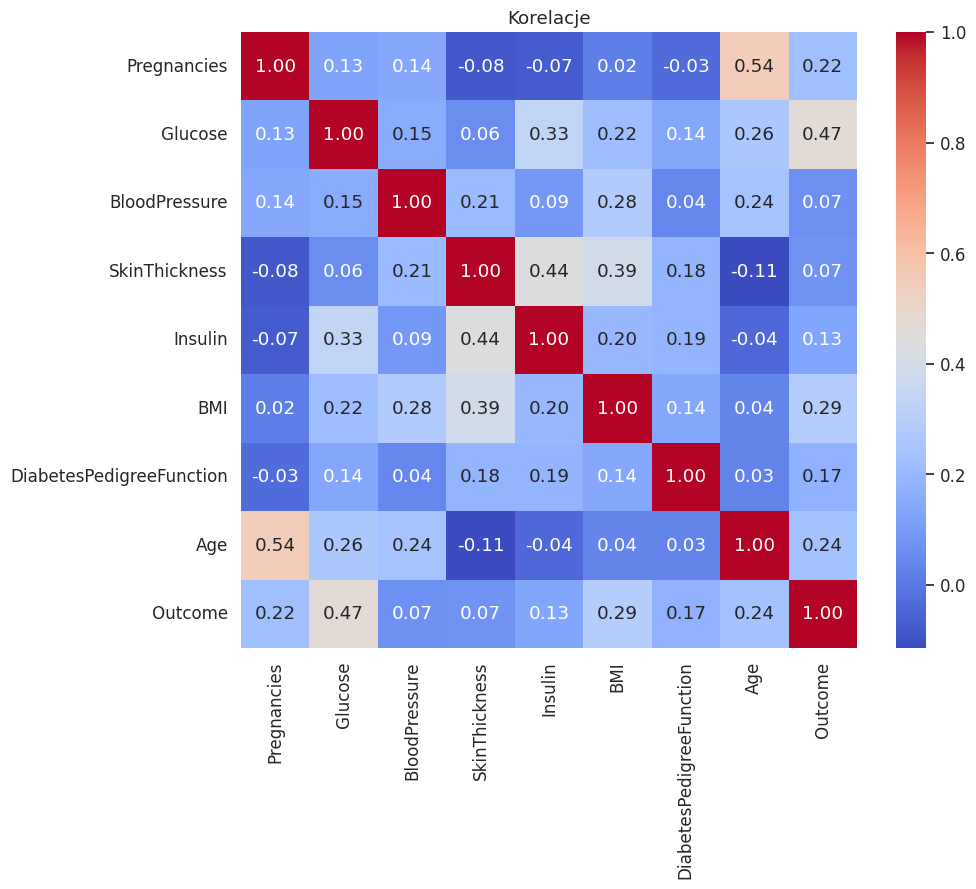

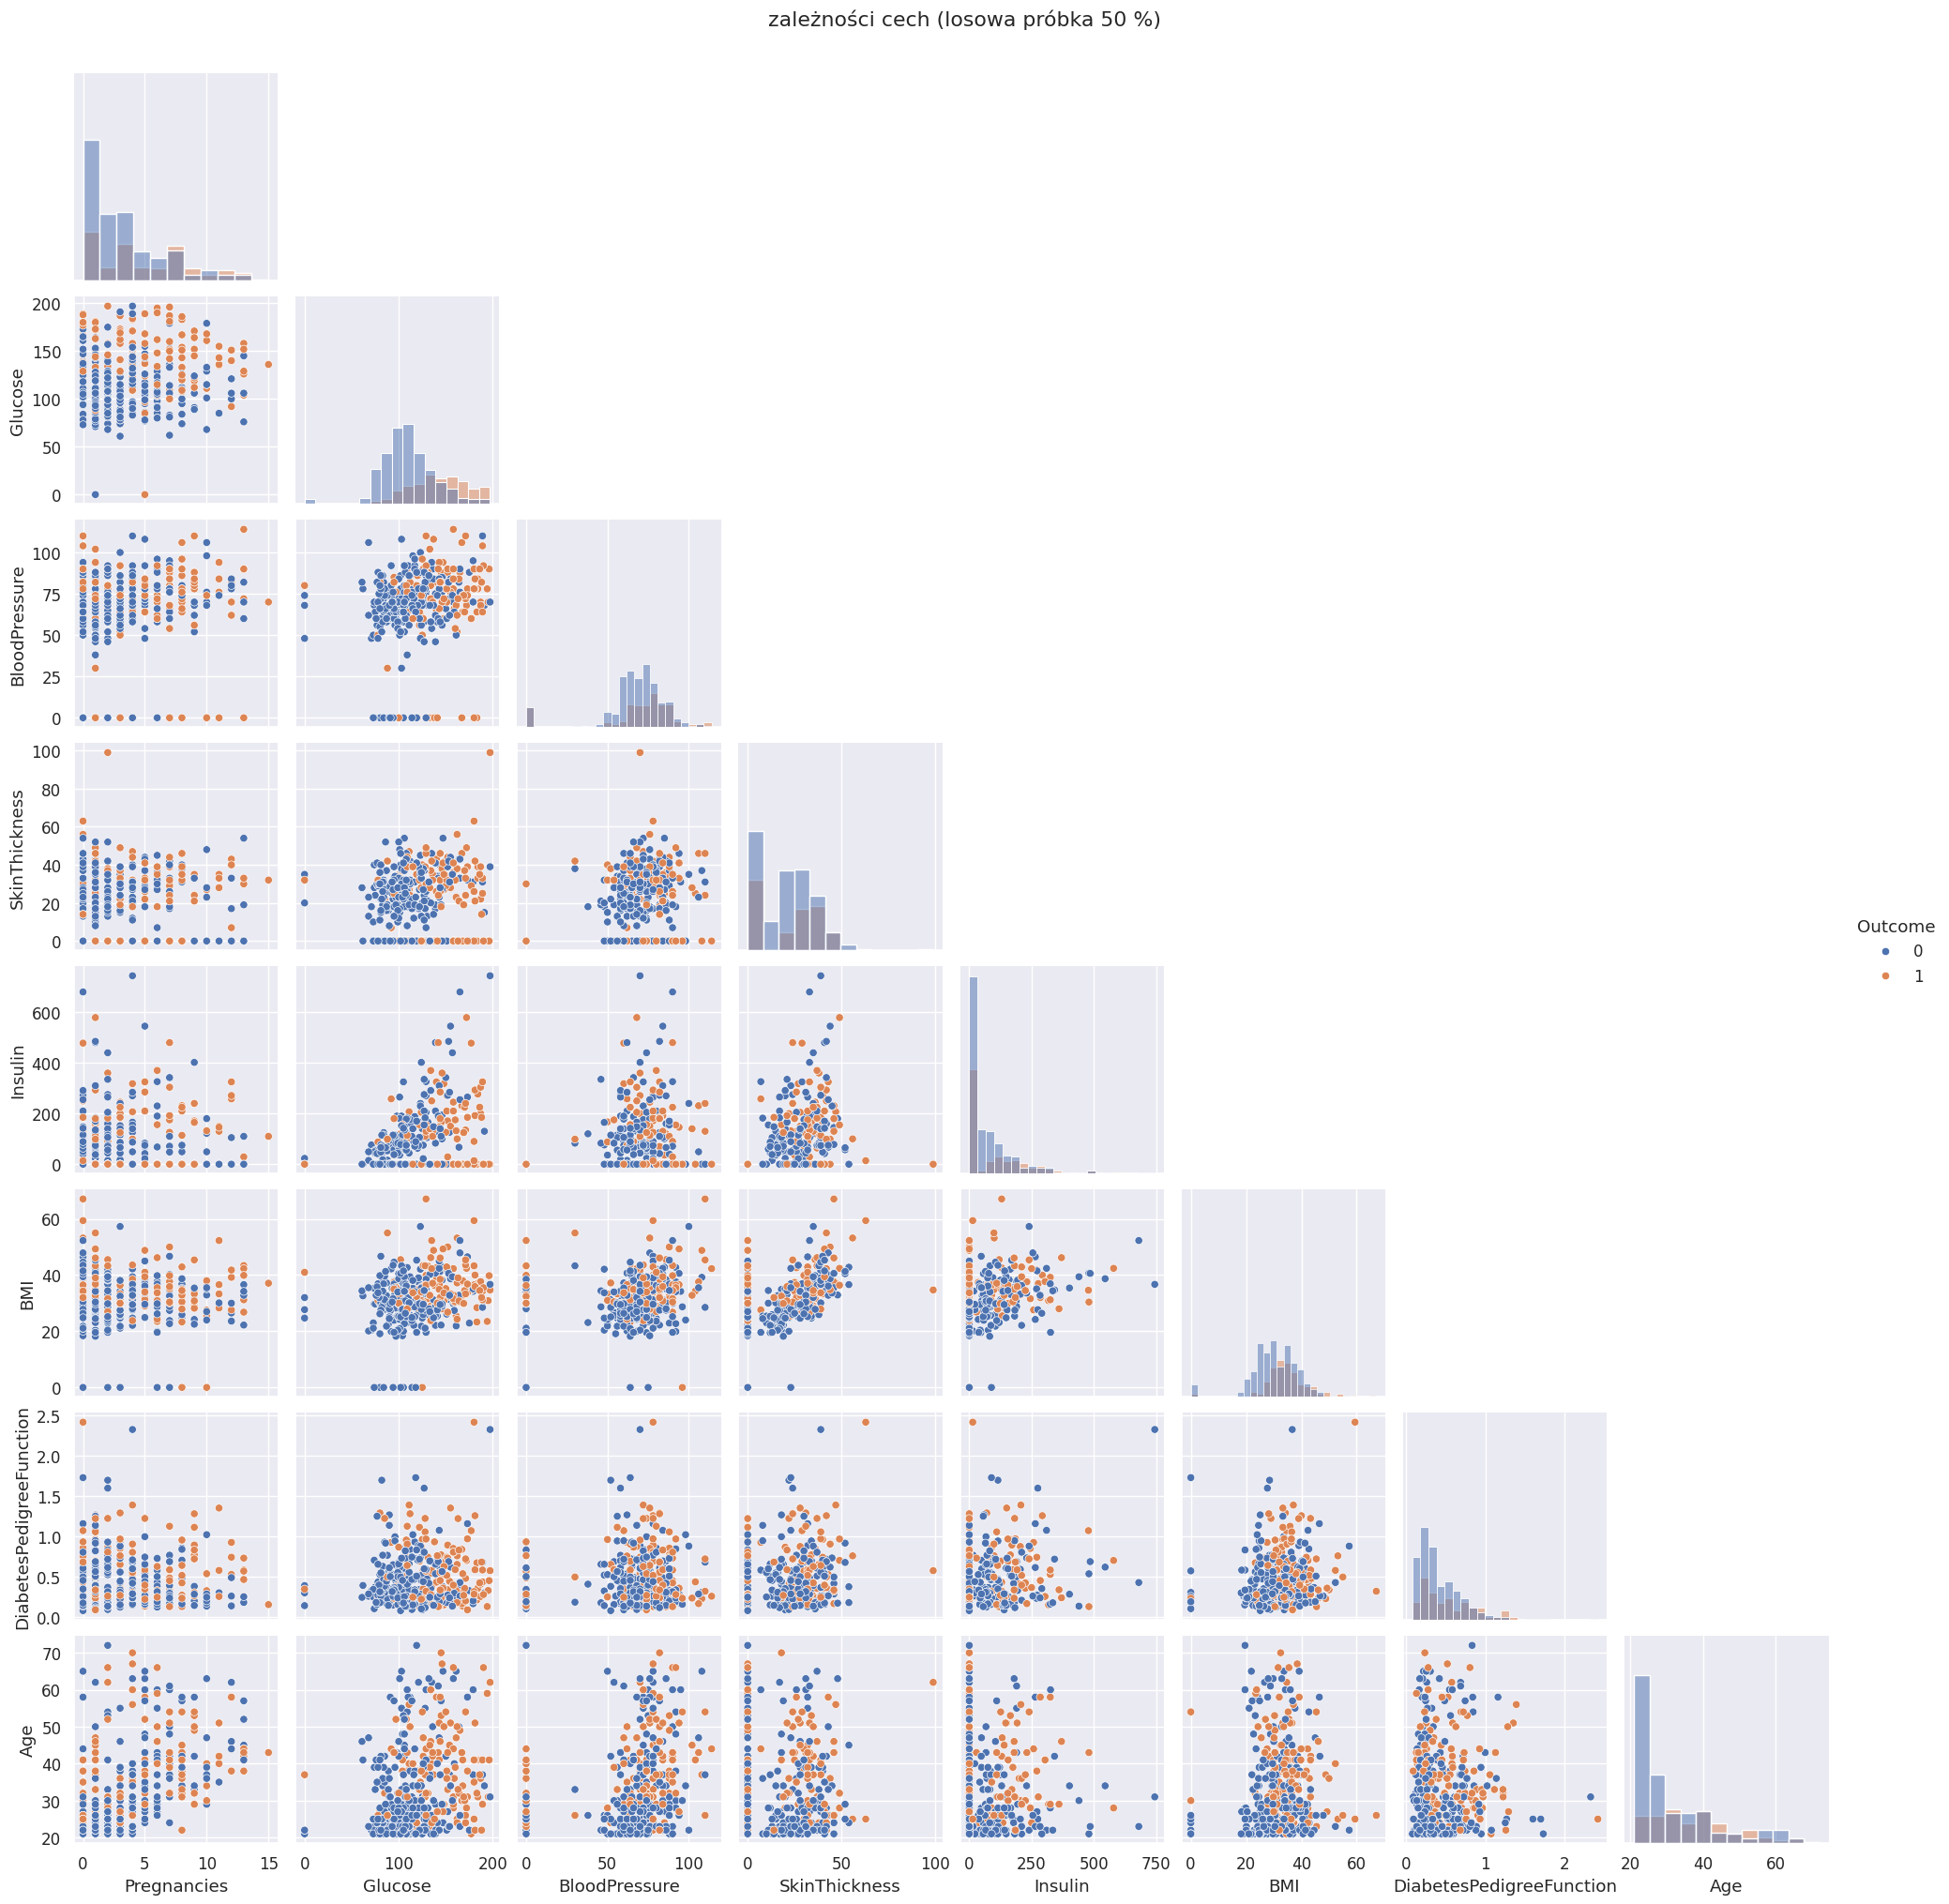

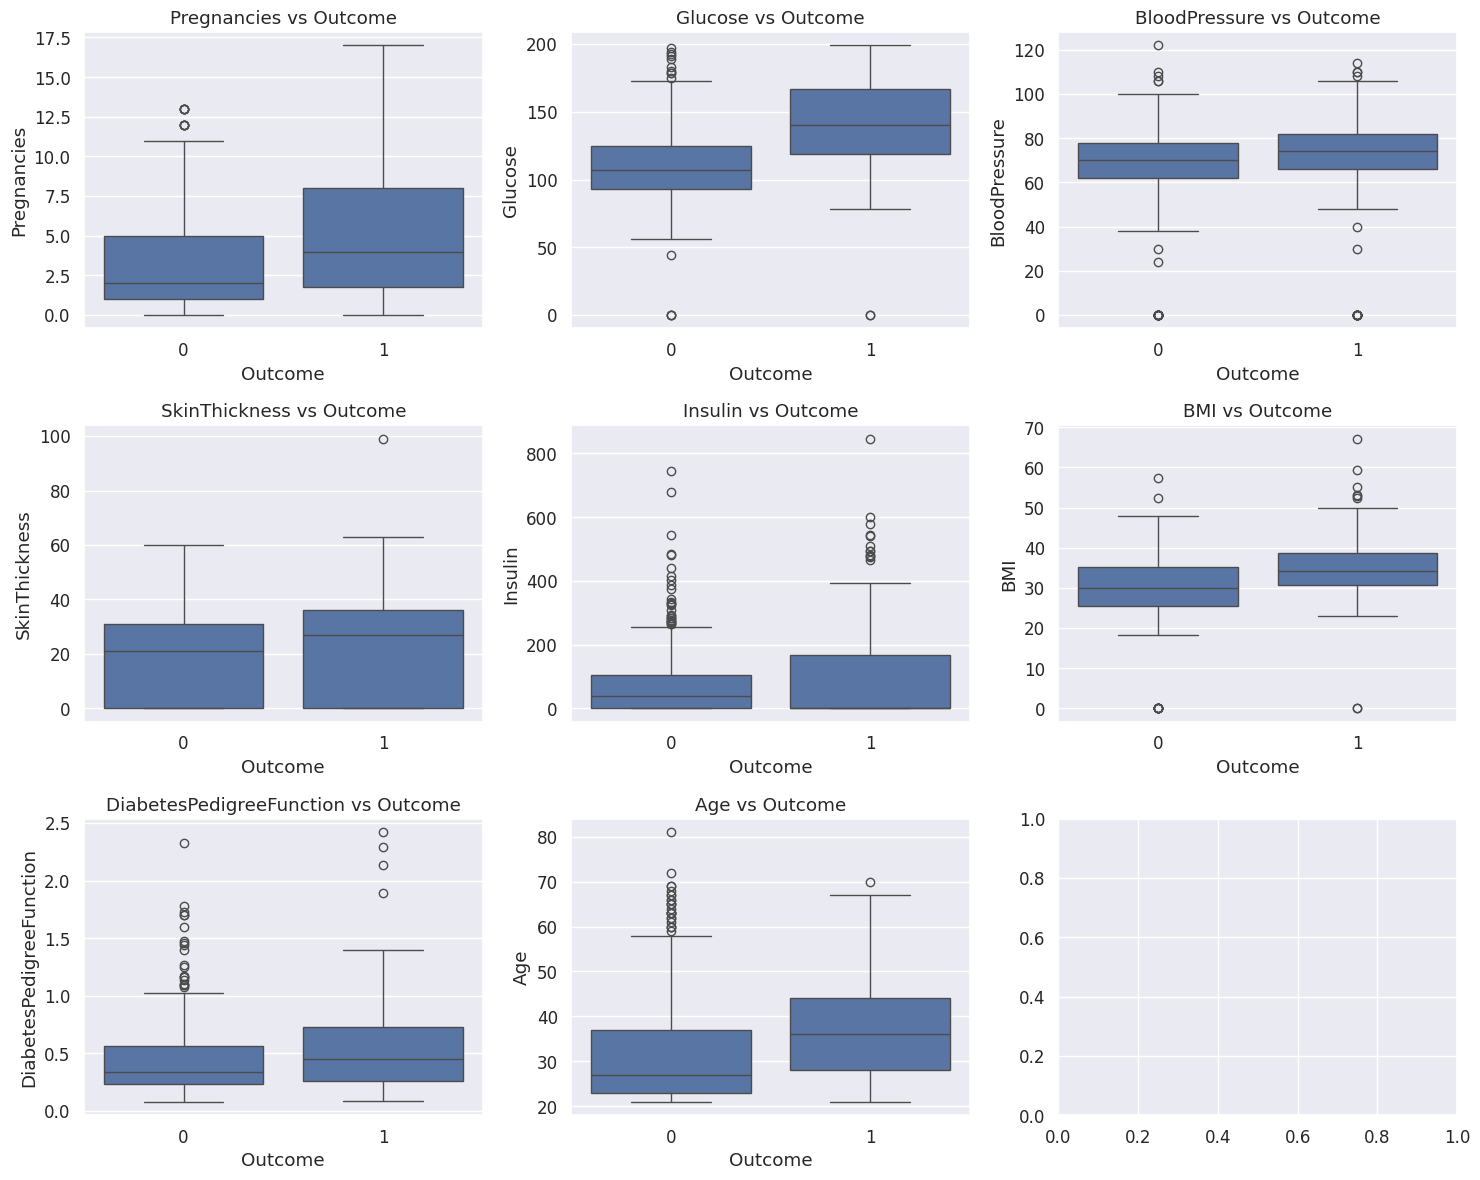

In [ ]:
plt.style.use("default")  # ustawienie stylu wykresów
sns.set(font_scale=1.1)  # skalowanie czcionki
pd.set_option("display.max_columns", None)  # pełny widok kolumn

path = kagglehub.dataset_download("uciml/pima-indians-diabetes-database")  # pobranie zbioru danych
path = pathlib.Path(path)  # konwersja ścieżki
csv_path = (path / "diabetes.csv").as_posix()  # ścieżka do pliku CSV

df = pd.read_csv(csv_path)  # wczytanie danych
print(f" Załadowano {df.shape[0]} wierszy i {df.shape[1]} kolumn.\n")  # podsumowanie rozmiaru
display(df.head())  # podgląd danych
df.info()  # informacja o DataFrame
print("\nStatystyki opisowe:")  # nagłówek statystyk
display(df.describe().T)  # statystyki opisowe

class_counts = df["Outcome"].value_counts().rename(index={0:"Brak cukrzycy",1:"Cukrzyca"})  # zliczenie klas
print("\nRozkład klas:")  # nagłówek rozkładu klas
display(class_counts)  # wyświetlenie rozkładu

fig, ax = plt.subplots()  # inicjalizacja wykresu
ax.pie(class_counts, labels=class_counts.index, autopct="%1.1f%%", startangle=90)  # wykres kołowy
ax.set_title("Bilans klas – Outcome")  # tytuł wykresu
plt.show()  # wyświetlenie wykresu

zero_cols = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]  # kolumny z wartościami zero
zero_summary = (df[zero_cols] == 0).sum().to_frame("Liczba zer")  # zliczenie zer
print("\nWartości 0 (traktowane jako braki):")  # nagłówek braków
display(zero_summary)  # wyświetlenie liczby zer

num_cols = df.columns.drop("Outcome")  # cechy numeryczne
fig, axes = plt.subplots(len(num_cols)//3 + 1, 3, figsize=(15, 12))  # siatka wykresów
axes = axes.flat  # spłaszczenie listy osi
for i, col in enumerate(num_cols):  # iteracja po cechach
    sns.histplot(df[col], kde=True, ax=axes[i])  # histogram z KDE
    axes[i].set_title(col)  # tytuł wykresu
plt.tight_layout()  # dopasowanie układu
plt.show()  # wyświetlenie histogramów

corr = df.corr(numeric_only=True)  # macierz korelacji
plt.figure(figsize=(10, 8))  # rozmiar mapy cieplnej
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", square=True)  # wykres korelacji
plt.title("Korelacje")  # tytuł mapy
plt.show()  # wyświetlenie mapy

sns.pairplot(df.sample(frac=0.5, random_state=42), hue="Outcome",
             vars=num_cols, diag_kind="hist", corner=True)  # analiza par cech
plt.suptitle("zależności cech (losowa próbka 50 %)", y=1.02)  # tytuł zbiorczy
plt.show()  # wyświetlenie pairplot

fig, axes = plt.subplots(len(num_cols)//3 + 1, 3, figsize=(15, 12))  # siatka wykresów pudełkowych
axes = axes.flat  # spłaszczenie listy osi
for i, col in enumerate(num_cols):  # iteracja po cechach
    sns.boxplot(x="Outcome", y=col, data=df, ax=axes[i])  # wykres pudełkowy
    axes[i].set_title(f"{col} vs Outcome")  # tytuł wykresu
plt.tight_layout()  # dopasowanie układu
plt.show()  # wyświetlenie wykresów pudełkowych


## Preprocessing

In [ ]:
target = "Outcome"  # zmienna celu
feature_cols = df.columns.drop(target).tolist()  # lista cech
zero_mask_cols = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]  # kolumny do zamiany zer

X = df[feature_cols].copy()  # dane wejściowe
y = df[target].copy()  # etykiety

class ZeroToNaN(BaseEstimator, TransformerMixin):  # klasa konwersji zer
    def __init__(self, cols):
        self.cols = cols  # kolumny
    def fit(self, X, y=None):
        return self  # dopasowanie
    def transform(self, X):
        X = X.copy()  # kopia danych
        X[self.cols] = X[self.cols].replace(0, np.nan)  # zamiana zer na NaN
        return X  # zwrócenie danych

class Winsorizer(BaseEstimator, TransformerMixin):  # klasa winsoryzacji
    def __init__(self, lower_q=0.01, upper_q=0.99):
        self.lower_q = lower_q  # kwantyl dolny
        self.upper_q = upper_q  # kwantyl górny
    def fit(self, X, y=None):
        q_low  = np.nanquantile(X, self.lower_q, axis=0)  # dolny kwantyl
        q_high = np.nanquantile(X, self.upper_q, axis=0)  # górny kwantyl
        self.bounds_ = np.vstack([q_low, q_high]).T  # macierz progów
        return self  # zwrócenie instancji
    def transform(self, X):
        X_df = X.copy()  # kopia DataFrame
        index = X_df.index if hasattr(X_df, "index") else None  # indeksy
        X = X_df.to_numpy() if hasattr(X_df, "to_numpy") else X_df.copy()  # konwersja na tablicę
        for i in range(X.shape[1]):  # iteracja po kolumnach
            lo, hi = self.bounds_[i]  # zakres
            X[:, i] = np.clip(X[:, i], lo, hi)  # przycięcie wartości
        return pd.DataFrame(X, columns=feature_cols, index=index)  # zwrócenie DataFrame

numeric_pipeline_svm = Pipeline([
    ("zero_to_nan", ZeroToNaN(zero_mask_cols)),  # konwersja zer
    ("imputer",     SimpleImputer(strategy="median")),  # imputacja medianą
    ("winsor",      Winsorizer(0.01, 0.99)),  # winsoryzacja
    ("scaler",      StandardScaler())  # skalowanie
])

preprocessor_svm = ColumnTransformer([
    ("num", numeric_pipeline_svm, feature_cols)  # przetwarzanie numerycznych
], remainder="drop")  # odrzucenie pozostałych

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,  # udział testu
    stratify=y,  # zachowanie proporcji klas
    random_state=42  # ziarno losowości
)

X_train_proc = preprocessor_svm.fit_transform(X_train)  # dopasowanie i przetwarzanie treningu
X_test_proc  = preprocessor_svm.transform(X_test)  # przetwarzanie testu

print(f"Rozmiary po preprocessingu: X_train={X_train_proc.shape}, X_test={X_test_proc.shape}")  # podsumowanie rozmiarów


Rozmiary po preprocessingu: X_train=(614, 8), X_test=(154, 8)


## EDA po preprocessingu

Po preprocessingu: X_train=(614, 8), X_test=(154, 8)



,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
353,-0.855842,-1.064104,-0.860858,-2.036813,-1.268315,-0.787625,0.336349,-0.798945
711,0.361973,0.143354,0.490937,-0.233405,-1.534800,-0.423641,-0.111619,0.573469
373,-0.551388,-0.560996,-1.198807,1.329548,-0.579827,0.380155,-0.791515,-0.713169
46,-0.855842,0.814164,-1.367782,0.007049,-0.161334,-0.408475,0.285516,-0.370065
682,-1.160296,-0.896401,-0.691884,1.209321,-0.431329,1.851255,-0.343546,-0.970496



Statystyki opisowe (train, wartości po standaryzacji):


,count,mean,std,min,25%,50%,75%,max
Pregnancies,614.0,5.207561e-17,1.000815,-1.160296,-0.855842,-0.246935,0.666426,2.797602
Glucose,614.0,-1.157236e-17,1.000815,-1.788914,-0.762239,-0.158510,0.612921,2.491188
BloodPressure,614.0,4.166049e-16,1.000815,-2.381628,-0.691884,-0.015987,0.659911,3.003586
SkinThickness,614.0,1.272959e-16,1.000815,-2.277268,-0.473860,0.007049,0.367731,2.531820
Insulin,614.0,2.003464e-16,1.000815,-1.534800,-0.228833,-0.161334,-0.093835,4.833581
BMI,614.0,1.562268e-15,1.000815,-1.955405,-0.723169,0.001006,0.622811,2.664303
DiabetesPedigreeFunction,614.0,2.401264e-16,1.000815,-1.212415,-0.727973,-0.291125,0.524591,3.847852
Age,614.0,-1.128305e-16,1.000815,-1.056272,-0.798945,-0.370065,0.659245,2.803640



Rozkład klas (train):


,count
Outcome,
Brak cukrzycy,400
Cukrzyca,214


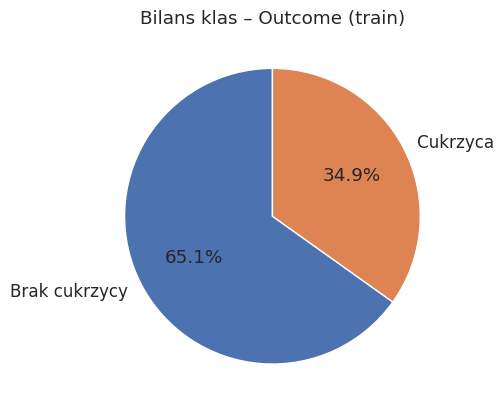

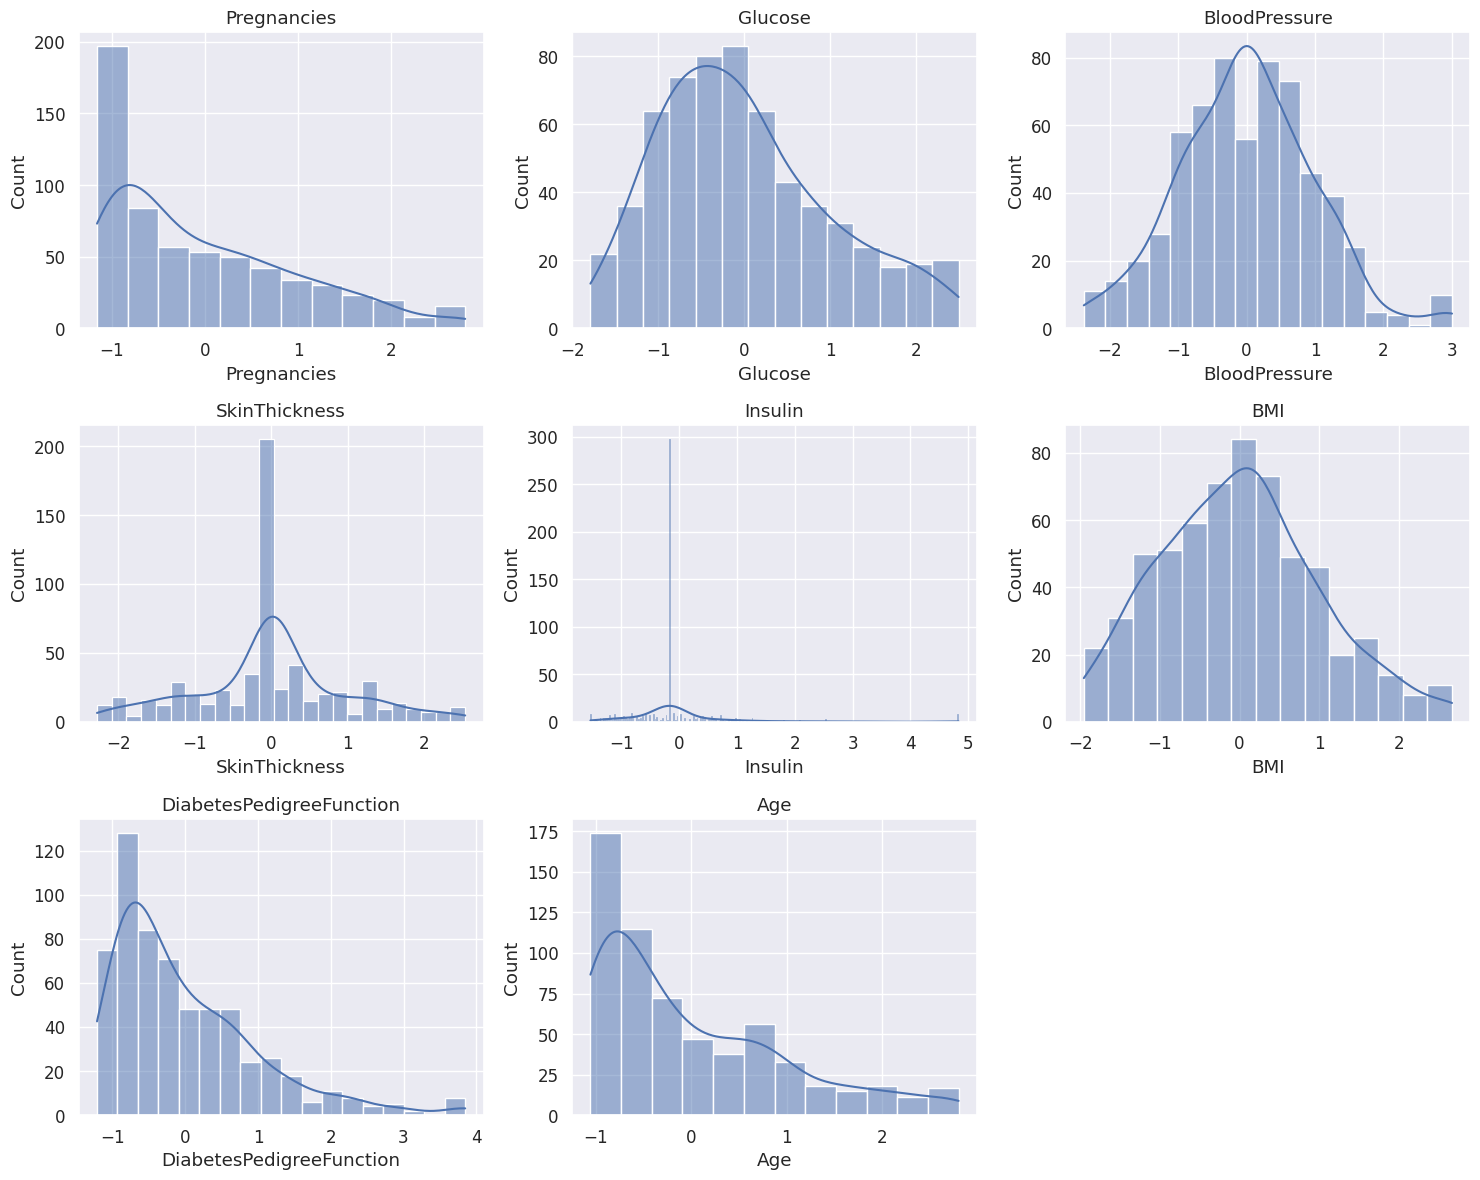

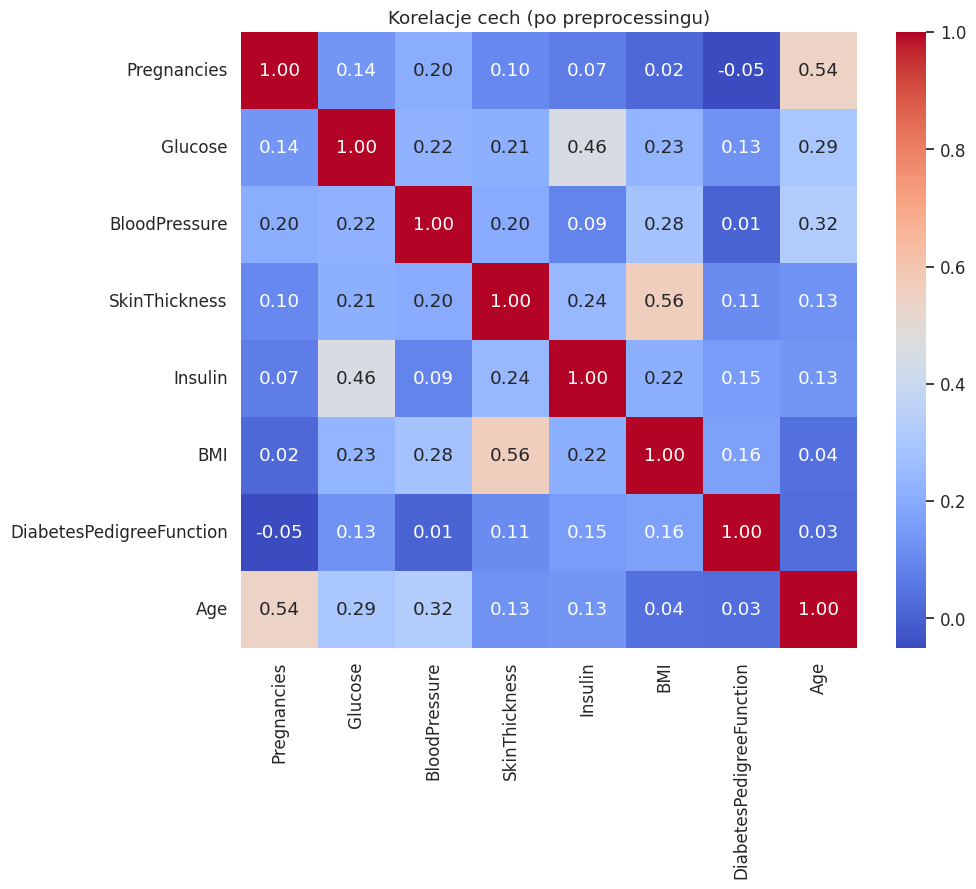

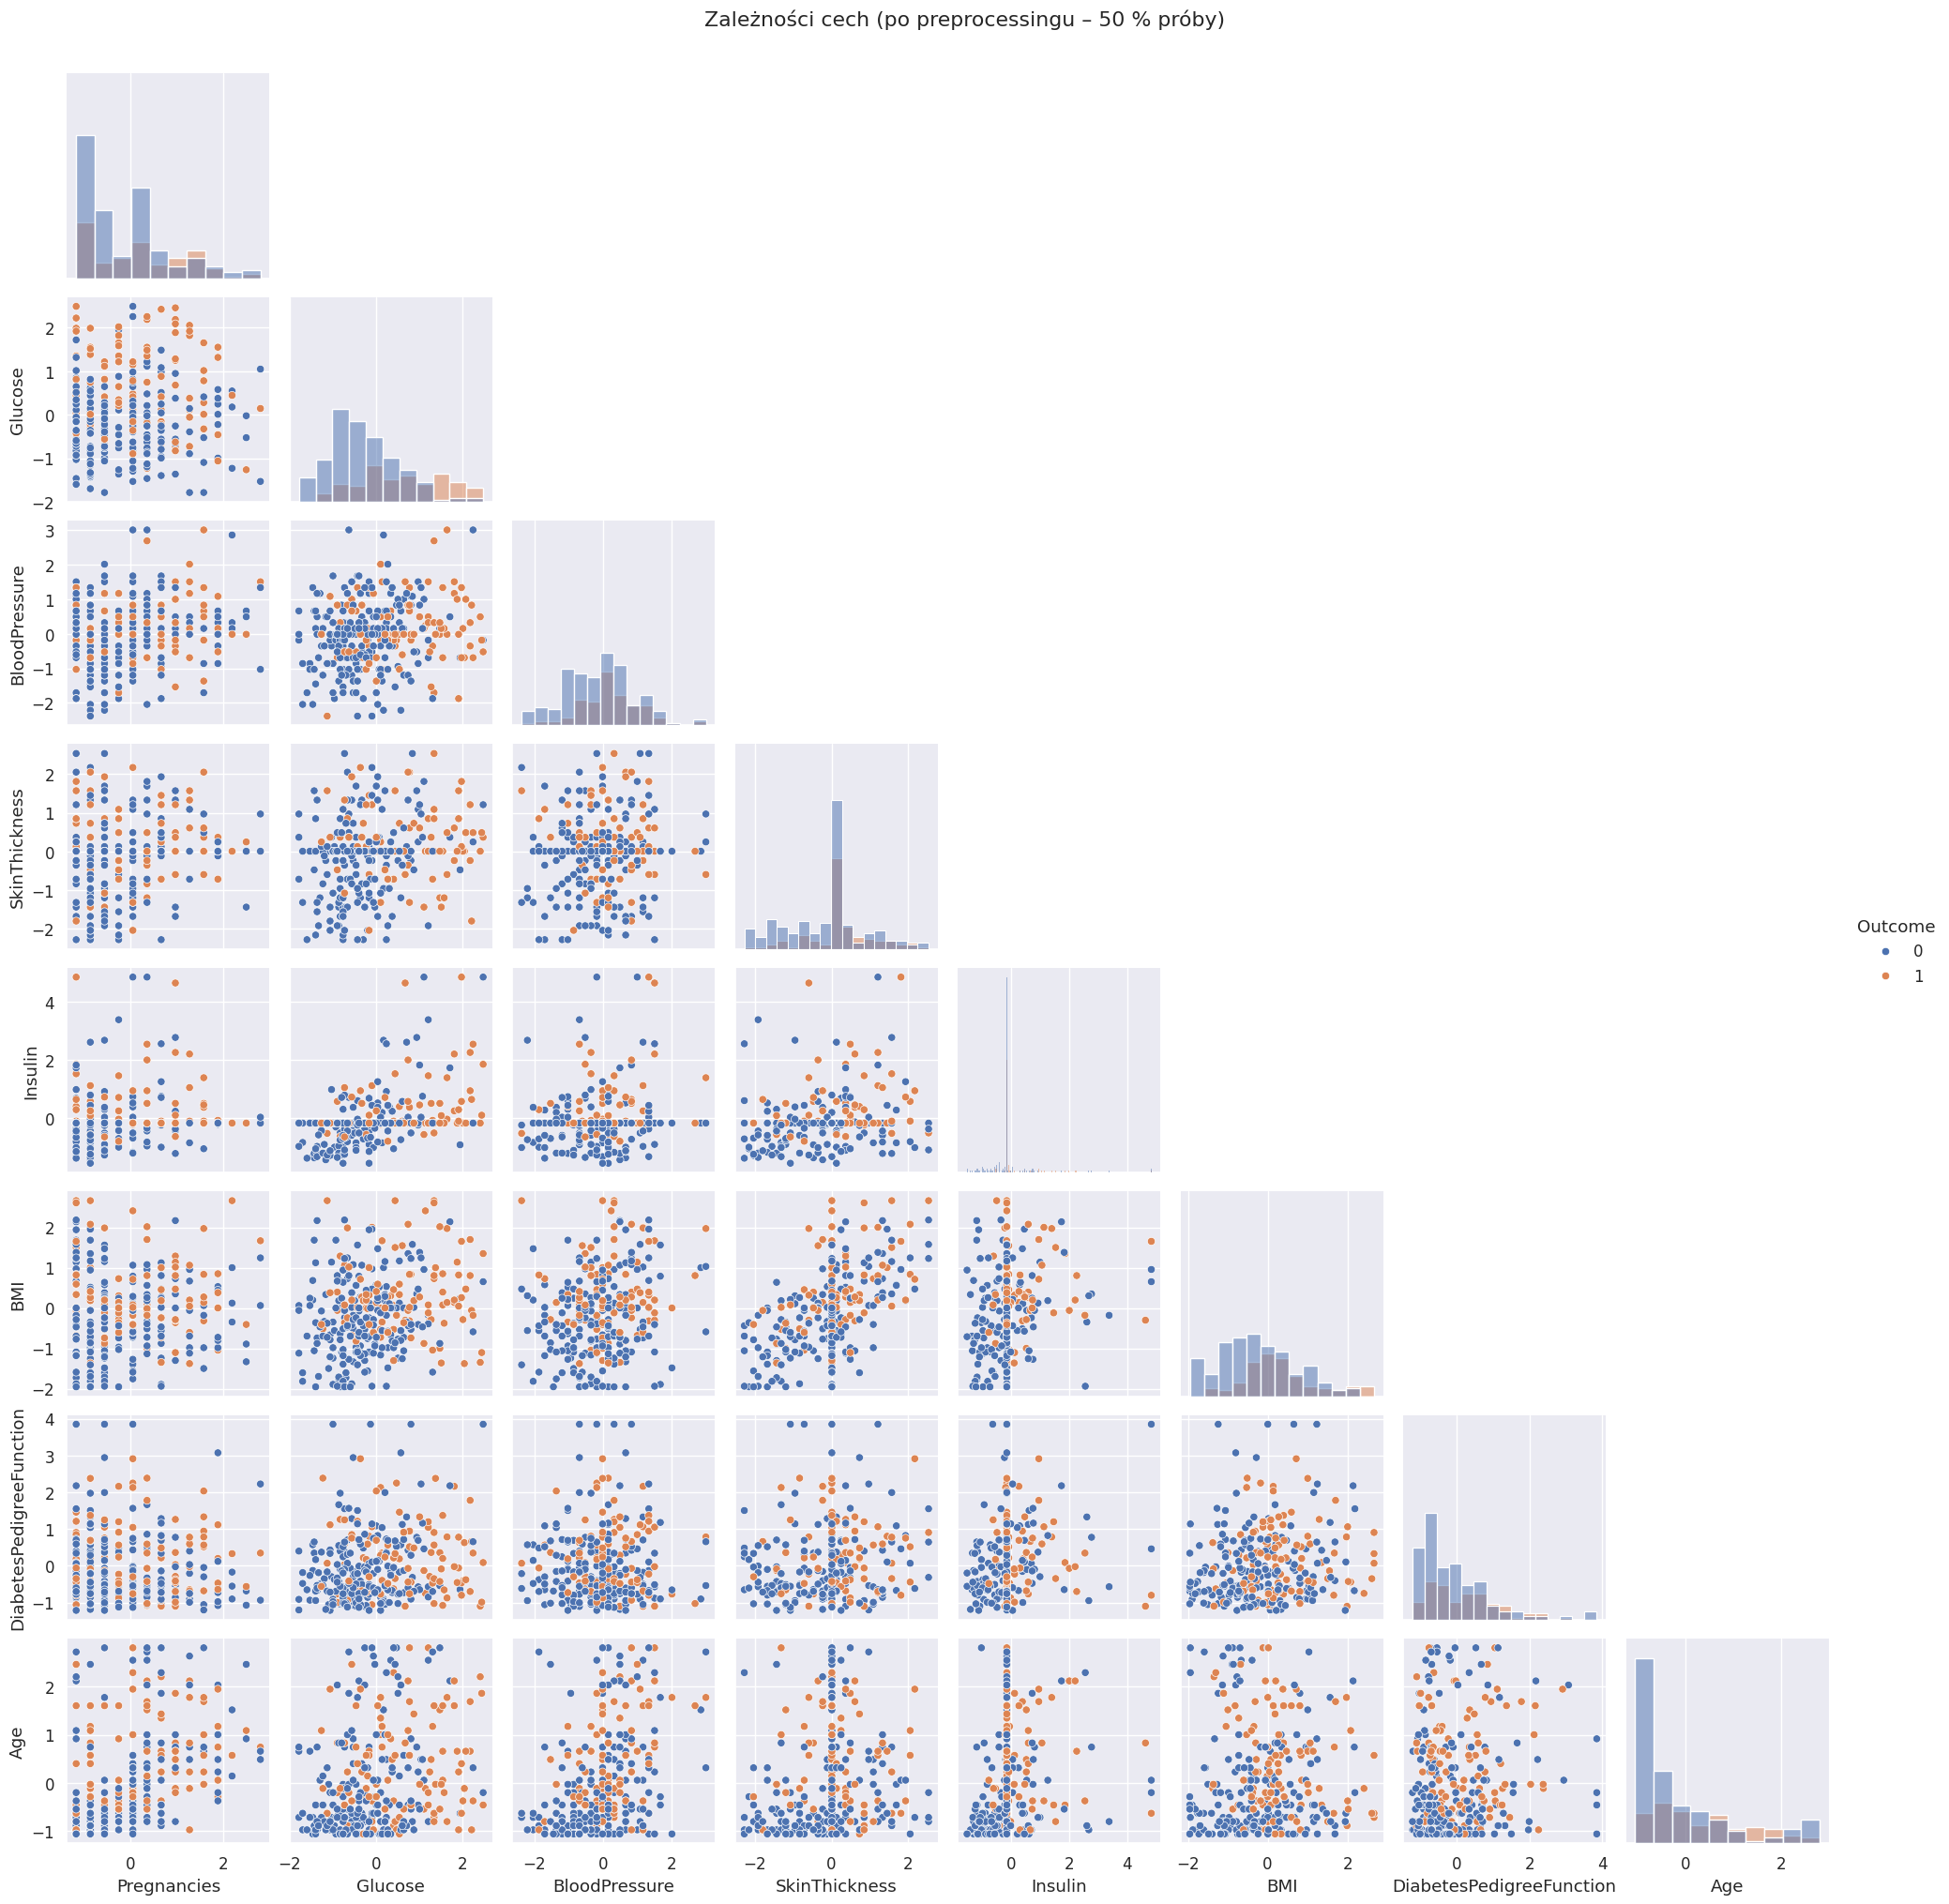

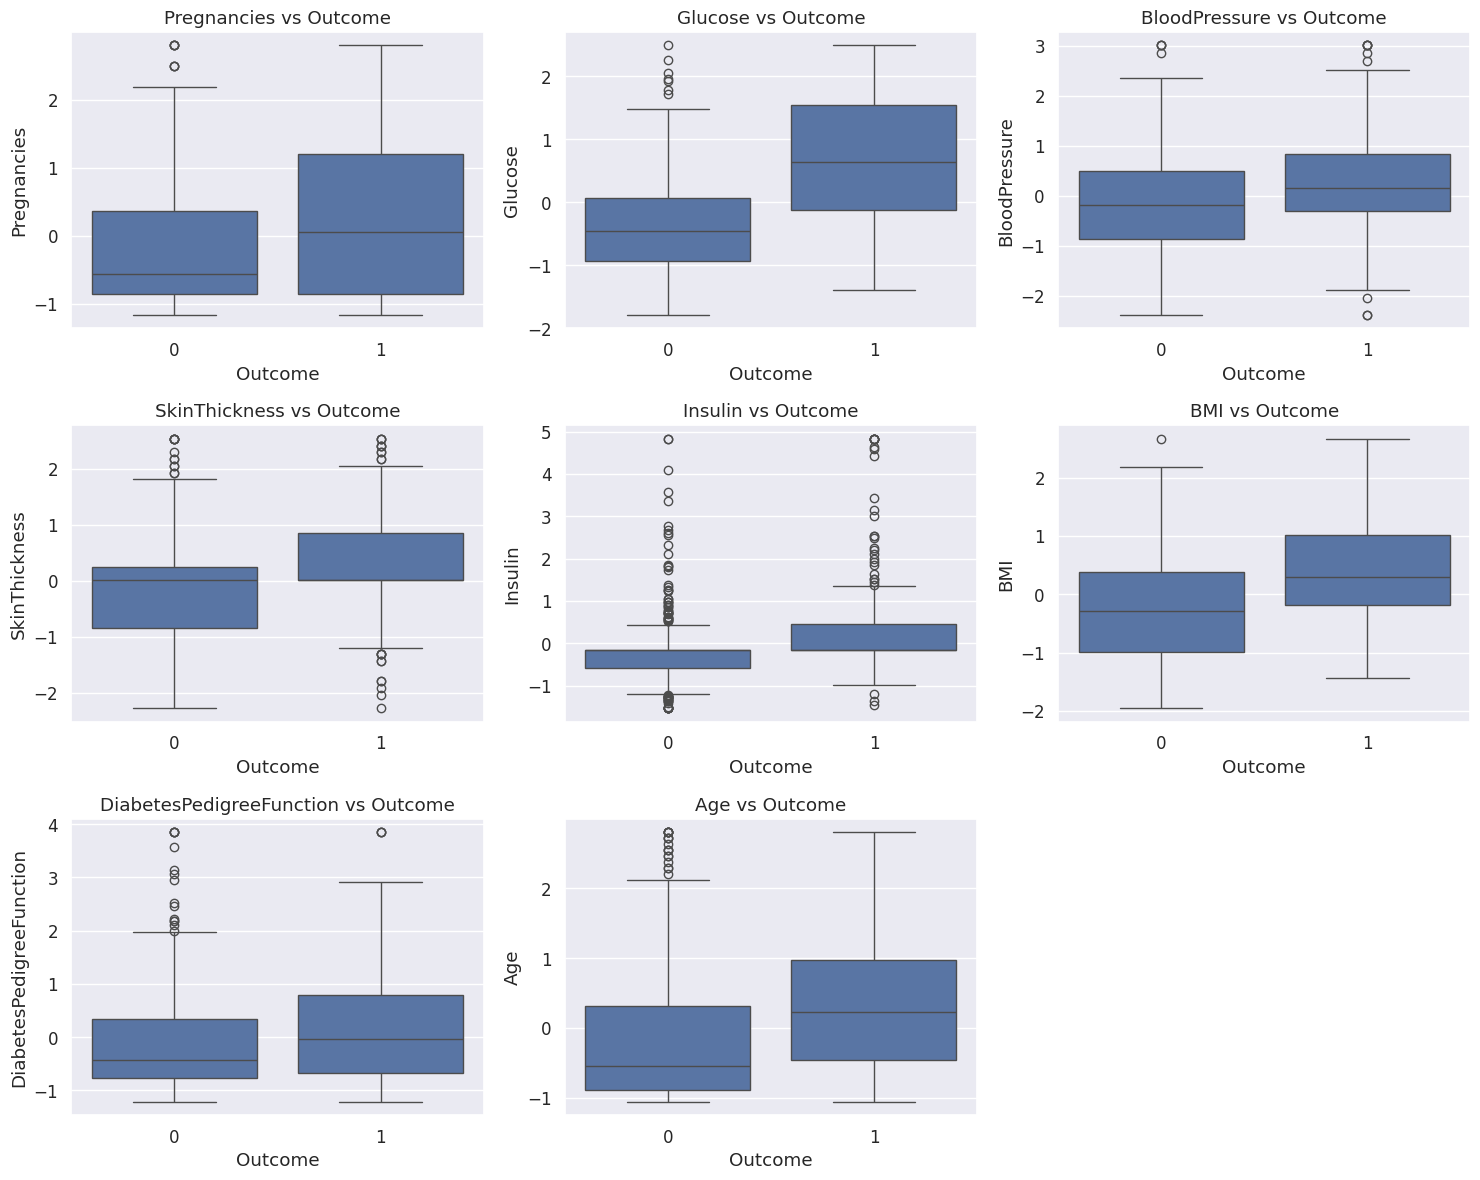

In [ ]:
proc_cols = feature_cols  # nazwy cech
X_train_df = pd.DataFrame(X_train_proc, columns=proc_cols, index=X_train.index)  # utworzenie DataFrame train
X_test_df  = pd.DataFrame(X_test_proc,  columns=proc_cols, index=X_test.index)   # utworzenie DataFrame test

print(f"Po preprocessingu: X_train={X_train_df.shape}, X_test={X_test_df.shape}\n")  # rozmiary danych po preprocessingu
display(X_train_df.head())  # podgląd danych train
print("\nStatystyki opisowe (train, wartości po standaryzacji):")  # nagłówek statystyk
display(X_train_df.describe().T)  # statystyki opisowe

class_counts_train = y_train.value_counts().rename(index={0: "Brak cukrzycy", 1: "Cukrzyca"})  # zliczenie klas train
print("\nRozkład klas (train):")  # nagłówek rozkładu klas
display(class_counts_train)  # wyświetlenie rozkładu klas

fig, ax = plt.subplots()  # inicjalizacja wykresu
ax.pie(class_counts_train, labels=class_counts_train.index,
       autopct="%1.1f%%", startangle=90)  # wykres kołowy klas
ax.set_title("Bilans klas – Outcome (train)")  # tytuł wykresu
plt.show()  # wyświetlenie wykresu

num_cols = proc_cols  # cechy numeryczne
fig, axes = plt.subplots(len(num_cols)//3 + 1, 3, figsize=(15, 12))  # siatka wykresów
axes = axes.flat  # spłaszczenie listy osi
for i, col in enumerate(num_cols):  # iteracja po cechach
    sns.histplot(X_train_df[col], kde=True, ax=axes[i])  # histogram cechy
    axes[i].set_title(col)  # tytuł pod wykresem
for ax in axes[len(num_cols):]:  # wyłączenie pustych osi
    ax.axis("off")
plt.tight_layout()  # dopasowanie układu
plt.show()  # wyświetlenie histogramów

corr = X_train_df.corr()  # macierz korelacji
plt.figure(figsize=(10, 8))  # ustawienie rozmiaru mapy
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", square=True)  # mapa cieplna korelacji
plt.title("Korelacje cech (po preprocessingu)")  # tytuł mapy
plt.show()  # wyświetlenie mapy

sns.pairplot(
    pd.concat([X_train_df, y_train], axis=1).sample(frac=0.5, random_state=42),  # próbka danych
    hue=target, vars=num_cols, diag_kind="hist", corner=True  # ustawienia pairplot
)
plt.suptitle("Zależności cech (po preprocessingu – 50 % próby)", y=1.02)  # tytuł zbiorczy
plt.show()  # wyświetlenie pairplot

fig, axes = plt.subplots(len(num_cols)//3 + 1, 3, figsize=(15, 12))  # siatka wykresów pudełkowych
axes = axes.flat  # spłaszczenie listy osi
for i, col in enumerate(num_cols):  # iteracja po cechach
    sns.boxplot(x=y_train, y=X_train_df[col], ax=axes[i])  # wykres pudełkowy cechy
    axes[i].set_title(f"{col} vs Outcome")  # tytuł pod wykresem
for ax in axes[len(num_cols):]:  # wyłączenie pustych osi
    ax.axis("off")
plt.tight_layout()  # dopasowanie układu
plt.show()  # wyświetlenie wykresów pudełkowych


## Hiperparametry + Trening

In [ ]:
models_dir = Path(os.getcwd()) / "models"  # katalog modeli
models_dir.mkdir(parents=True, exist_ok=True)  # utworzenie katalogu

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # walidacja krzyżowa

# 1) Prosty model – kernel linear, tylko C
svm_simple = SVC(kernel='linear', probability=True, random_state=42)  # inicjalizacja SVM liniowego
param_simple = {'C': loguniform(1e-3, 1e3)}  # zakres C
search_simple = RandomizedSearchCV(
    svm_simple,
    param_simple,
    n_iter=20,  # liczba prób
    scoring='roc_auc',  # metryka AUC
    cv=cv,  # przekazanie CV
    random_state=42,
    n_jobs=-1
)
search_simple.fit(X_train_proc, y_train)  # strojenie modelu
joblib.dump(search_simple.best_estimator_, models_dir / "svm_simple.joblib")  # zapis modelu

# 2) Model umiarkowany – kernel RBF, C + gamma
svm_mid = SVC(kernel='rbf', probability=True, random_state=42)  # inicjalizacja SVM RBF
param_mid = {
    'C':     loguniform(1e-3, 1e3),  # zakres C
    'gamma': loguniform(1e-4, 1e-1)  # zakres gamma
}
search_mid = RandomizedSearchCV(
    svm_mid,
    param_mid,
    n_iter=40,  # liczba prób
    scoring='roc_auc',  # metryka AUC
    cv=cv,  # przekazanie CV
    random_state=42,
    n_jobs=-1
)
search_mid.fit(X_train_proc, y_train)  # strojenie modelu
joblib.dump(search_mid.best_estimator_, models_dir / "svm_mid.joblib")  # zapis modelu

# 3) Zaawansowany model – kernel poly + rozszerzone parametry
svm_adv = SVC(kernel='poly', probability=True, random_state=42)  # inicjalizacja SVM wielomianowego
param_adv = {
    'C':       loguniform(1e-3, 1e3),  # zakres C
    'gamma':   loguniform(1e-4, 1e-1),  # zakres gamma
    'degree':  [2, 3, 4],  # stopnie wielomianu
    'coef0':   uniform(0, 1)  # współczynnik zerowy
}
search_adv = RandomizedSearchCV(
    svm_adv,
    param_adv,
    n_iter=60,  # liczba prób
    scoring='roc_auc',  # metryka AUC
    cv=cv,  # przekazanie CV
    random_state=42,
    n_jobs=-1
)
search_adv.fit(X_train_proc, y_train)  # strojenie modelu
joblib.dump(search_adv.best_estimator_, models_dir / "svm_advanced.joblib")  # zapis modelu


['/content/models/svm_advanced.joblib']

## Ewaluacja

,CV_ROC_AUC,CV_Accuracy,CV_BalAcc,CV_Precision,CV_Recall,CV_F1,Test_Accuracy,Test_BalAcc,Test_Precision,Test_Recall,Test_F1,Test_ROC_AUC,Test_PR_AUC,Test_MCC
Model,,,,,,,,,,,,,,
Simple,0.846,0.778,0.718,0.776,0.519,0.62,0.727,0.675,0.643,0.500,0.562,0.805,0.661,0.375
Mid,0.846,0.778,0.718,0.777,0.519,0.62,0.721,0.661,0.641,0.463,0.538,0.804,0.660,0.354
Advanced,0.846,0.775,0.712,0.776,0.505,0.61,0.753,0.695,0.711,0.500,0.587,0.805,0.663,0.432


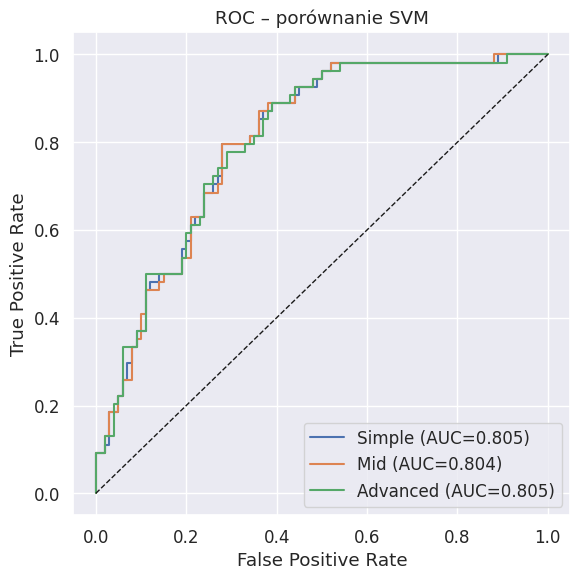

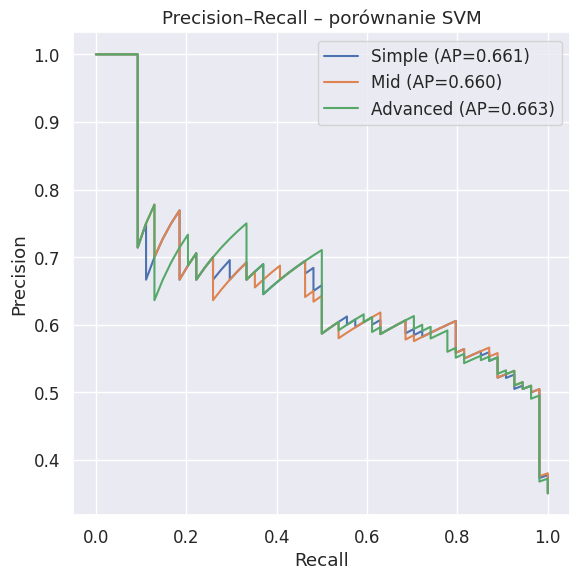

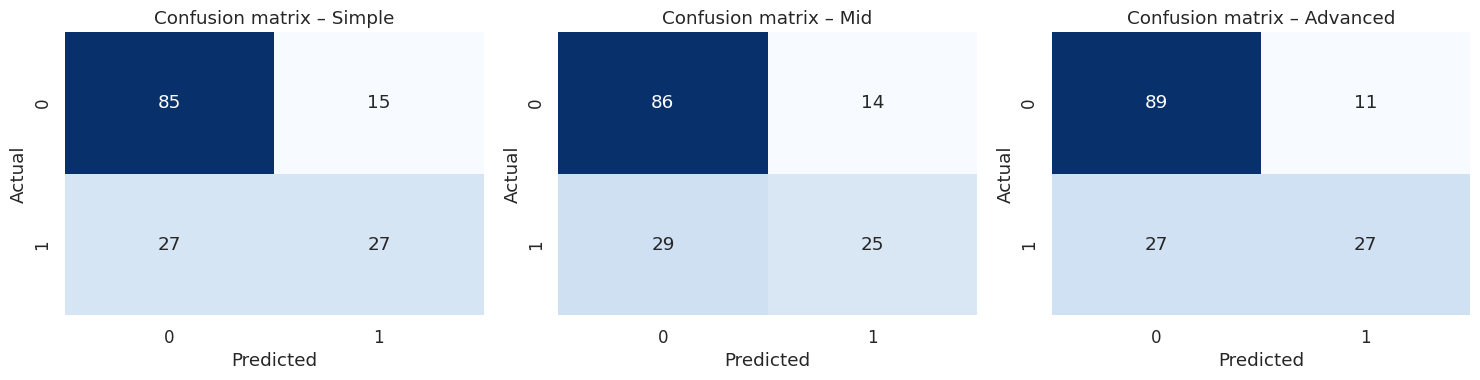

In [ ]:
models_dir = Path(os.getcwd()) / "models"  # katalog modeli
models = {
    "Simple":   joblib.load(models_dir / "svm_simple.joblib"),  # wczytanie modelu prostego
    "Mid":      joblib.load(models_dir / "svm_mid.joblib"),     # wczytanie modelu umiarkowanego
    "Advanced": joblib.load(models_dir / "svm_advanced.joblib"),# wczytanie modelu zaawansowanego
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # walidacja krzyżowa
records = []  # zbiór wyników
curves = {}   # słownik krzywych

for tag, model in models.items():  # iteracja po modelach
    cv_res = cross_validate(
        model,
        X_train_proc,
        y_train,
        cv=cv,
        scoring={  # słownik metryk
            "ROC_AUC": "roc_auc",
            "Accuracy": "accuracy",
            "BalAcc": "balanced_accuracy",
            "Precision": "precision",
            "Recall": "recall",
            "F1": "f1",
        },
        n_jobs=-1,
        return_train_score=False
    )

    y_proba = model.predict_proba(X_test_proc)[:, 1]  # prawdopodobieństwa pozytywnej klasy
    y_pred = model.predict(X_test_proc)  # predykcje

    rec = {  # agregacja metryk
        "Model":        tag,
        "CV_ROC_AUC":   cv_res["test_ROC_AUC"].mean(),  # średnie AUC z CV
        "CV_Accuracy":  cv_res["test_Accuracy"].mean(),  # średnia Accuracy z CV
        "CV_BalAcc":    cv_res["test_BalAcc"].mean(),    # średnia BalAcc z CV
        "CV_Precision": cv_res["test_Precision"].mean(), # średnia Precision z CV
        "CV_Recall":    cv_res["test_Recall"].mean(),    # średnia Recall z CV
        "CV_F1":        cv_res["test_F1"].mean(),        # średnia F1 z CV
        "Test_Accuracy":       accuracy_score(y_test, y_pred),          # dokładność testu
        "Test_BalAcc":         balanced_accuracy_score(y_test, y_pred), # zbalansowana dokładność testu
        "Test_Precision":      precision_score(y_test, y_pred, zero_division=0),  # precyzja testu
        "Test_Recall":         recall_score(y_test, y_pred, zero_division=0),     # czułość testu
        "Test_F1":             f1_score(y_test, y_pred, zero_division=0),         # F1 testu
        "Test_ROC_AUC":        roc_auc_score(y_test, y_proba),    # AUC ROC testu
        "Test_PR_AUC":         average_precision_score(y_test, y_proba),  # AUC Precision–Recall
        "Test_MCC":            matthews_corrcoef(y_test, y_pred), # współczynnik MCC
    }
    records.append(rec)  # dodanie do listy

    fpr, tpr, _ = roc_curve(y_test, y_proba)  # punkty krzywej ROC
    prec, rec_, _ = precision_recall_curve(y_test, y_proba)  # punkty krzywej PR
    curves[tag] = {"fpr": fpr, "tpr": tpr, "prec": prec, "rec": rec_}  # zapis krzywych

metrics_df = pd.DataFrame(records).set_index("Model").round(3)  # DataFrame metryk
display(metrics_df)  # wyświetlenie tabeli metryk

plt.figure(figsize=(6, 6))  # inicjalizacja wykresu ROC
for tag, pts in curves.items():  # iteracja po krzywych ROC
    auc = metrics_df.loc[tag, "Test_ROC_AUC"]  # odczyt AUC
    plt.plot(pts["fpr"], pts["tpr"], label=f"{tag} (AUC={auc:.3f})")  # rysowanie krzywej
plt.plot([0, 1], [0, 1], "k--", lw=1)  # linia losowa
plt.xlabel("False Positive Rate")  # oś X
plt.ylabel("True Positive Rate")  # oś Y
plt.title("ROC – porównanie SVM")  # tytuł wykresu
plt.legend()  # legenda
plt.tight_layout()  # dopasowanie układu
plt.show()  # wyświetlenie wykresu

plt.figure(figsize=(6, 6))  # inicjalizacja wykresu Precision–Recall
for tag, pts in curves.items():  # iteracja po krzywych PR
    ap = metrics_df.loc[tag, "Test_PR_AUC"]  # odczyt AUC PR
    plt.plot(pts["rec"], pts["prec"], label=f"{tag} (AP={ap:.3f})")  # rysowanie krzywej
plt.xlabel("Recall")  # oś X
plt.ylabel("Precision")  # oś Y
plt.title("Precision–Recall – porównanie SVM")  # tytuł wykresu
plt.legend()  # legenda
plt.tight_layout()  # dopasowanie układu
plt.show()  # wyświetlenie wykresu

SHOW_CM = True  # flaga wyświetlania macierzy pomyłek
if SHOW_CM:
    fig, axes = plt.subplots(1, len(models), figsize=(5*len(models), 4))  # siatka macierzy
    for ax, (tag, model) in zip(axes, models.items()):  # iteracja po modelach
        cm = confusion_matrix(y_test, model.predict(X_test_proc))  # macierz pomyłek
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)  # rysowanie macierzy
        ax.set_title(f"Confusion matrix – {tag}")  # tytuł macierzy
        ax.set_xlabel("Predicted")  # oś X
        ax.set_ylabel("Actual")     # oś Y
    plt.tight_layout()  # dopasowanie układu
    plt.show()  # wyświetlenie macierzy
